In [150]:
%matplotlib inline
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import plotly.io as pio
from ase.data import chemical_symbols
from ase.data.colors import jmol_colors
from dadapy.data import Data
from dadapy.plot import get_dendrogram
from numpy.random import default_rng
from pinn.io import load_ds, load_runner
from sklearn.decomposition import PCA

rng = default_rng(0)
subsample = rng.choice(64000, size=5000, replace=False)
pio.renderers.default = "iframe"

In [461]:
def label_ver1(datum):
    """
    Label the elements given a ds, the ds will be falttened, label with the following rule:

                                        H_4
                      O                  |
    H_6 - C_6 - C_4 <                   C_1
                      O - H_1 -- N_1 <       > N_2 - C_5 - H_5
                                      \     /
                                H_3 - C_2 - C_3 - H_2

    | 0 |  0 | H_1 | active H        |
    | 1 |  1 | H_2 | H to SP2 carbon |
    | 1 |  2 | H_3 | H to SP2 carbon |
    | 1 |  3 | H_4 | H to SP2 carbon |
    | 2 |  4 | H_5 | H to SP3 carbon |
    | 2 |  5 | H_6 | H to SP3 carbon |
    | 3 |  6 | C_1 | SP2 carbon      |
    | 3 |  7 | C_2 | SP2 carbon      |
    | 3 |  8 | C_3 | SP2 carbon      |
    | 3 |  9 | C_4 | SP2 carbon      |
    | 4 | 10 | C_5 | SP3 carbon      |
    | 4 | 11 | C_6 | SP3 carbon      |
    | 5 | 12 | N_1 | SP2 nitrogen    |
    | 5 | 13 | N_2 | SP2 nitrogen    |
    | 6 | 14 | O_1 | both oxygen     |
    """
    from ase import Atoms, neighborlist
    from scipy import sparse

    atoms = Atoms(datum["elem"], positions=datum["coord"], cell=datum["cell"], pbc=True)
    (hydro,) = np.where(atoms.numbers == 1)
    (heavy,) = np.where(atoms.numbers != 1)
    natoms = len(atoms)
    cutoff = {
        ("H", "C"): 1.5,
        ("H", "N"): 1.8,
        ("H", "O"): 1.8,
        ("C", "C"): 2.0,
        ("C", "N"): 2.0,
        ("C", "O"): 2.0,
    }
    # build initial nl, see ase doc [ase/neighborlsit] ===================================
    nl_i, nl_j, nl_d = neighborlist.neighbor_list(
        "ijd", atoms, cutoff, self_interaction=False
    )
    conMat = sparse.dok_matrix((natoms, natoms), dtype=np.int8)
    conMat[nl_i, nl_j] = 1
    conMat[nl_j, nl_i] = 1
    CN_ANY = np.squeeze(np.asarray(conMat.sum(axis=1)))
    CN_HEAVY = np.squeeze(np.asarray(conMat[:,heavy].sum(axis=1)))
    types = -np.ones(natoms, dtype=int)
    types[(CN_HEAVY == 2) & (atoms.numbers == 7)] = 13
    types[(CN_HEAVY == 3) & (atoms.numbers == 7)] = 12
    types[atoms.numbers == 8] = 14
    ctypes = np.zeros(natoms, dtype=int)
    c2on = (atoms.numbers[nl_i]==6) & (atoms.numbers[nl_j]!=1) & (atoms.numbers[nl_j]!=6)
    np.add.at(ctypes, nl_i[c2on], types[nl_j[c2on]])
    types[ctypes==28] = 9
    types[ctypes==25] = 6
    types[ctypes==13] = 7
    types[(ctypes==12) & (CN_ANY==3)] = 8
    types[(ctypes==12) & (CN_ANY==4)] = 10
    types[(ctypes==0) & (atoms.numbers==6)] = 11
    sel = [np.where(nl_i == h_ia)[0] for h_ia in hydro]
    h_n1 = np.array([nl_j[_sel][np.argmin(nl_d[_sel])] for _sel in sel])
    types[hydro[(atoms.numbers[h_n1] == 8) | (atoms.numbers[h_n1] == 7)]] = 0
    types[hydro[types[h_n1] == 6]] = 1
    types[hydro[types[h_n1] == 7]] = 2
    types[hydro[types[h_n1] == 8]] = 3
    types[hydro[types[h_n1] == 10]] = 4
    types[hydro[types[h_n1] == 11]] = 5
    typ, cnt = np.unique(types, return_counts=True)
    assert (typ == np.arange(15, dtype=int)).all()
    assert (cnt == np.array([32, 32, 32, 32, 96, 96, 32, 32, 32, 32, 32, 32, 32, 32, 64], int)).all(), cnt
    return types


from tips.io import load_ds

ds = load_ds("../datasets/pils-50ps.yml", fmt="pinn")
all_types = []
for datum in ds[:100]:
    all_types.append(label_ver1(datum))
all_types = np.array(all_types).flatten()[subsample]

Indexing a generator based dataset, this can be slow.


In [373]:
import numpy as np
from matplotlib.colors import to_hex

In [541]:
tikz_tmpl = R"""
  \tikzset{font={\fontsize{8pt}{12}\selectfont}}
  {% for i, color in enumerate(type_colors) -%}
  \definecolor{T{{i}}}{HTML}{ {{-color-}} }
  {% endfor %}
  {% for i, color in enumerate(cluster_colors) -%}
  \definecolor{C{{i}}}{HTML}{ {{-color-}} }
  {% endfor %}
  \begin{sankeydiagram}
    \sankeyset{
      start style=simple, end style=simple,
      outin steps=2,
      ratio=4cm/5000,
      color/.style={fill/.style={draw=black,fill=#1}},
    }
    \def\vdistl{1mm}
    \def\vdistr{1.2mm}
    
    \def\hdist{1cm}

    % nodes
    \sankeynode{anchor=left,name=T0,quantity={{type_cnt[0]}}}
    {%- for i, cnt in enumerate(type_cnt[1:]) %}
    \sankeynode{anchor=left,name=T{{i+1}},quantity={{cnt}}, at={[yshift=-\vdistl]T{{i}}.right}}
    {%- endfor %}
    \sankeynode{anchor=left,name=C0,quantity={{cluster_cnt[0]}}, at={[xshift=\hdist]T0.left}}
    {%- for i, cnt in enumerate(cluster_cnt[1:]) %}
    \sankeynode{anchor=left,name=C{{i+1}},quantity={{cnt}}, at={[yshift=-\vdistr]C{{i}}.right}}
    {%- endfor %}
    
    % nodes
    {%- for i, (fork, label) in enumerate(zip(type_forks,type_labels)) %}
    \sankeyfork{T{{i}}}{ {{-fork-}} }
    \sankeyadvance*[color=T{{i}}]{T{{i}}}{2mm}
    \node[anchor=east] at (T{{i}}) {\ce{ {{-label-}} }};
    {%- endfor %}
    {%- for i, (fork, label) in enumerate(zip(cluster_forks,cluster_labels)) %}
    \sankeyfork{C{{i}}}{ {{-fork-}} }
    \sankeyadvance[color=C{{i}}]{C{{i}}}{2mm}
    \node[anchor=west] at (C{{i}}) { {{-label-}} };
    {%- endfor %}
    
    {%- for (color,out, in) in outin %}
    \sankeyoutin[color={{color}}]{ {{-out-}} }{ {{-in-}} }
    {%- endfor %}
    \begin{axis}[
      at={($(C0.left)+(0.8cm,0.2cm)$)},anchor=north west,width=5cm,
      xmin=0,xmax=18,axis x line=top,hide y axis]
    {%- for (i,x) in enumerate(cluster_x) %}
      \node at ({axis cs: {{x}},0}) (C{{i}}_x) {};
    {%- endfor %}
      \addplot[draw=none] {x};
    \end{axis}
    
    {%- for (i,x) in enumerate(cluster_cnt) %}
      \node [draw,circle,fill=C{{i}},inner sep=0.05cm] at (C{{i}}_x|-C{{i}}) (C{{i}}_a) {};
    {%- endfor %}
    {%- for c,(i,j) in enumerate(cluster_ij) %}
      \node at ($(C{{i}}_a)!0.5!(C{{j}}_a)$) (C{{c+len(cluster_cnt)}}_y) {};
      \node [fill=black, inner sep=0, outer sep=0] at (C{{c+len(cluster_cnt)}}_x|-C{{c+len(cluster_cnt)}}_y) (C{{c+len(cluster_cnt)}}_a) {};
      \draw[thick] (C{{i}}_a) -| (C{{c+len(cluster_cnt)}}_a);
      \draw[thick] (C{{j}}_a) -| (C{{c+len(cluster_cnt)}}_a);
    {%- endfor %}
  \end{sankeydiagram}
"""

In [546]:
import jinja2

def mktikz(gen, exp='../exp/prod-adam-run2'):
    latent = np.load(f"{exp}/analyses/latent/gen{gen}/latent.npy")
    latent = latent[subsample]
    dd = Data(latent)
    dd.compute_distances(maxk=31)
    dd.compute_density_kNN(k=30)
    dd.compute_clustering_ADP(Z=5)
    
    def cmap(i):
        cm = plt.get_cmap("tab20", 20)
        if i>2:
            i+= 1
            if len(np.unique(dd.cluster_assignment))<11:
                i+=1
            if i>6:
                i+=1
        chex = to_hex(cm(i))[1:]
        return chex
    
    type_uniq, type_cnt = np.unique(all_types, return_counts=True)
    cluster_uniq, cluster_cnt = np.unique(dd.cluster_assignment, return_counts=True)
    links = np.zeros([len(type_uniq), len(cluster_uniq)], dtype=int)
    for i in type_uniq:
        for j in cluster_uniq:
            links[i,j] = np.sum((all_types==i) & (dd.cluster_assignment==j))
            
    type_colors = [to_hex(jmol_colors[i])[1:] for i in [1]*6+[6]*6+[7]*2+[8]]
    #type_labels = [f"$\mathrm{{{symb}_{{{i+1}}}}}$" for symb, i in zip('HHHHHHCCCCCCNNO', range(15))]
    type_labels = [f"$\mathrm{{{symb}_{{{i if i else ' '}}}}}$" for symb, i in 
                   zip('HHHHHHCCCCCCNNO', [1,2,3,4,5,6,1,2,3,4,5,6,1,2,None])]
    
    cluster_colors = [cmap(i) for i in np.unique(dd.cluster_assignment)]
    cluster_labels = [str(int(i+1)) for i in np.unique(dd.cluster_assignment)]
    cluster_sort = np.argsort(np.argmax(links, axis=0))
    links = links[:,cluster_sort]
    cluster_cnt = cluster_cnt[cluster_sort]
    type_forks = [','.join([f'{l}/T{i}-C{j}' for j, l in enumerate(link) if l])
                  for i,link in enumerate(links)]
    cluster_forks = [','.join([f'{l}/C{i}-T{j}' for j, l in enumerate(link) if l])
                     for i,link in enumerate(links.T)]
    outin = [(f'C{j}', f'T{i}-C{j}',f'C{j}-T{i}') for (i,j), l in np.ndenumerate(links) if l]
    
    nd = int((dd.N_clusters * dd.N_clusters - dd.N_clusters) / 2)
    Dis = np.empty(nd, dtype=float)
    nl = 0
    Fmax = max(dd.log_den)
    Rho_bord_m = np.copy(dd.log_den_bord)
    
    for i in range(dd.N_clusters - 1):
        for j in range(i + 1, dd.N_clusters):
            Dis[nl] = Fmax - Rho_bord_m[cluster_sort[i]][cluster_sort[j]]
            nl = nl + 1
    Z = sp.cluster.hierarchy.single(Dis)
    
    environment = jinja2.Environment()
    template = environment.from_string(tikz_tmpl)
    tikz = template.render(
        zip=zip,
        len=len,
        enumerate=enumerate,
        type_colors=type_colors,
        cluster_colors=cluster_colors,
        type_uniq=type_uniq,
        type_cnt=type_cnt,
        type_labels=type_labels,
        type_forks=type_forks,
        cluster_uniq=cluster_uniq,
        cluster_cnt=cluster_cnt,
        cluster_labels=cluster_labels,
        cluster_forks=cluster_forks,
        cluster_x=list(Fmax-dd.log_den[dd.cluster_centers])+list(Z[:,2]),
        cluster_ij=Z[:,:2].astype(int),
        outin=outin,
        links=links[:,cluster_sort]
    )
    with open(f'gen{gen}.tikz', 'w') as f:
        f.write(tikz)
    #get_dendrogram(dd)
    
for gen in [0,14,30,39]:
    mktikz(gen)

FileNotFoundError: [Errno 2] No such file or directory: '../exp/prod-adam-run2/analyses/latent/gen39/latent.npy'

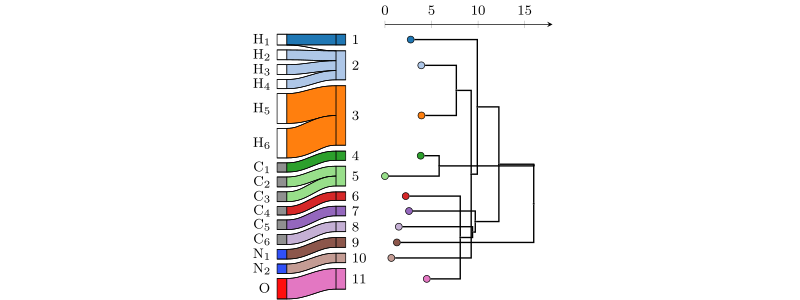

In [543]:
%%tikz -f svg -x $preamble --size 800,300 -S gen30.svg
\input{gen30.tikz}

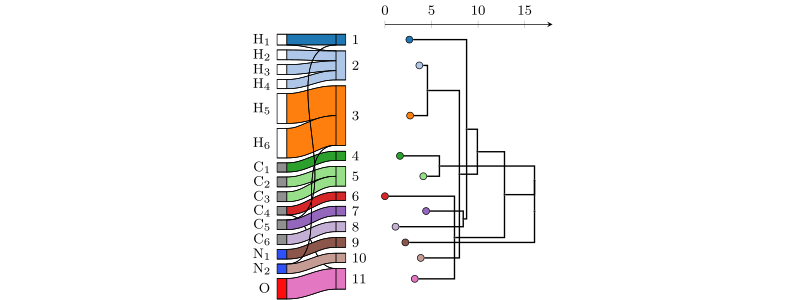

In [544]:
%%tikz -f svg -x $preamble --size 800,300 -S gen14.svg
\input{gen14.tikz}

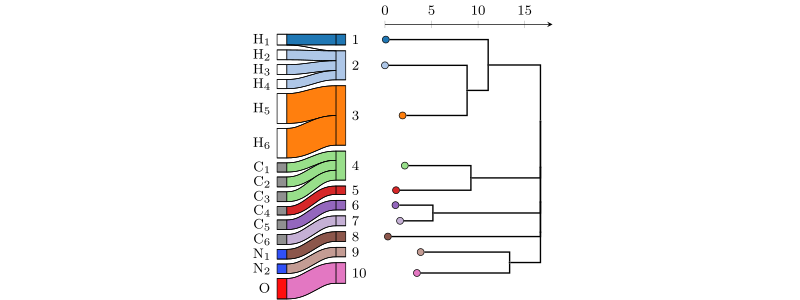

In [545]:
%%tikz -f svg -x $preamble --size 800,300 -S gen0.svg
\input{gen0.tikz}

In [440]:
%load_ext tikzmagic
preamble = r'''
\usepackage{tikz}\usepackage{pgfplots}\usepackage{sankey}\usepackage[version=4]{mhchem}\usetikzlibrary{arrows.meta,positioning,calc}
'''

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


In [ ]:
def int_to_roman(input):
    """ Convert an integer to a Roman numeral. 
    
    Reference: 
    - https://www.oreilly.com/library/view/python-cookbook/0596001673/ch03s24.html
    """

    if not isinstance(input, type(1)):
        raise TypeError, "expected integer, got %s" % type(input)
    if not 0 < input < 4000:
        raise ValueError, "Argument must be between 1 and 3999"
    ints = (1000, 900,  500, 400, 100,  90, 50,  40, 10,  9,   5,  4,   1)
    nums = ('M',  'CM', 'D', 'CD','C', 'XC','L','XL','X','IX','V','IV','I')
    result = []
    for i in range(len(ints)):
        count = int(input / ints[i])
        result.append(nums[i] * count)
        input -= ints[i] * count
    return ''.join(result)

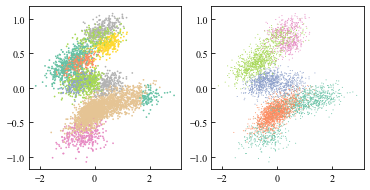

In [11]:
f, axs = plt.subplots(1, 2, figsize=[6, 3])
pca = PCA(n_components=2)
xy = pca.fit_transform(latent)


# ax = axs[seed-1,1]
dd = Data(latent)
dd.compute_distances(maxk=31)
dd.compute_density_kNN(k=30)
dd.compute_clustering_ADP(Z=2.5)
cmap = plt.get_cmap("Set2", len(dd.cluster_indices))
axs[0].scatter(xy[:, 0], xy[:, 1], c=cmap(dd.cluster_assignment), ec="none", s=3)
axs[1].scatter(xy[:, 0], xy[:, 1], color=cmap(all_types), ec="none", s=1)
# for elem in [1,6,7,8]:
#     # idx = (elems == elem)
#     axs[1].scatter(xy[idx,0], xy[idx,1], color=cmap(all_types), ec='none', s=1)
# ax.set_xticks([]); ax.set_yticks([]);
# for i, cc in enumerate(dd.cluster_centers):
#     ax.text(xy[cc,0], xy[cc,1], i,  bbox = dict(boxstyle="circle", fc=cmap(i)))
#
#     ax =axs[seed-1,2]
#     plt.sca(axs[seed-1,2])
#     get_dendrogram(dd, cmap='Set1')
#     ax.set_xticks([]); ax.set_yticks([]);
#     ax.set_xlabel(None); ax.set_ylabel(None);
# axs[0,0].legend()
# plt.tight_layout()
plt.savefig("adam_clustering.png")